<center>
<a href="https://www.vision.rwth-aachen.de/">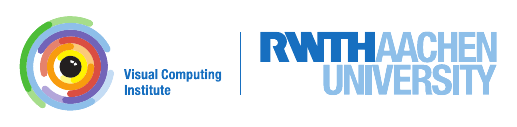</a>
</center>

# Computer Vision Exercises

**Assistants:**
<br>
Alexey Nekrasov &lt;nekrasov@vision.rwth-aachen.de&gt;
<br>
Jens Piekenbrinck &lt;piekenbrinck@vision.rwth-aachen.de&gt;

The assignments are **mandatory**!

We want to provide you with an interactive learning experience, so the assignments rely on [Jupyter](https://jupyter.org/) notebooks which you can run locally on your computer. The RWTH also offers a [JupyterHub](https://jupyter.rwth-aachen.de/) where you can run notebooks. If you have any questions, please contact us.

Make sure you fill in any place in *code cells* that says:
```python
# YOUR CODE HERE
raise NotImplementedError()
```

Make sure you fill in any place in *text cells* that says:
<br>

`YOUR ANSWER HERE`


### Submission:

⏰ Due date: 2023-05-14 23:59:00

**Important**:
Follow the instructions below when submitting your attempt.\
Submissions not following these instructions will not be graded.

1. Submit in **teams of 3 or 4 students**, add their names and matriculation numbers below. Only **one team member should upload** the solutions.
2. **Use jupyter notebook**. Other notebook-editing software (e.g. jupyter-lab, pycharm) might corrupt the notebook files and could have issues with displaying matplotlib interactively.
3. **Do not remove, modify or duplicate** any given cells, except those in which you need to fill in your implementation. You can add new cells in order to present additional texts or plots.
4. **Restart the kernel and re-run the whole notebook** once before submission. After this step, the cell id should be incremental from top to bottom, and all plots should be displayed.
5. **Submit only the `.ipynb` files**, do not upload archives (zip, rar, tar, etc.), images or datasets.
6. **Do not change the filenames** of the `.ipynb` files.

Team members (names and matriculation numbers):
* Batuhan Sakal - 429275
* Sagar Veerkar - 430086
* Talip Batuhan YILMAZ - 441368
* 

# Sliding-Window Object Detection

In this exercise we will implement a simple car detector. To accomplish this, we will first implement a feature descriptor similar to the Histogram of Oriented Gradients (HOG). Then using the features computed for (small) image patches with fixed size, we will train a support vector machine (SVM) classifier, to classify whether the input patch corresponds to a car. 

In the end, given a test image with arbitary shape, we will run our classifier over the image in a sliding window (patch) fashion. We will generate detections at the places where the classifier is very confident that the patch contains a car.

You may refer to the original HOG paper, or the following two tutorials, in case you want to freshen up your knowledge on HOG a little bit:

- N. Dalal and B. Triggs: Histograms of oriented gradients for human detection. CVPR 2005. http://lear.inrialpes.fr/people/triggs/pubs/Dalal-cvpr05.pdf
- https://www.learnopencv.com/histogram-of-oriented-gradients/
- http://mccormickml.com/2013/05/09/hog-person-detector-tutorial/

In [1]:
%%html
<!-- Run this cell to add heading letters per subtask (like a, b, c) -->
<style>
body {counter-reset: section;}
h2:before {counter-increment: section;
           content: counter(section, lower-alpha) ") ";}
</style>

In [2]:
%matplotlib notebook
import glob
import os
import re
import time

import cv2
import imageio.v3 as iio
import matplotlib.pyplot as plt
import numpy as np
import scipy.ndimage
import sklearn.svm


def plot_multiple(
    images,
    titles=None,
    colormap="viridis",
    max_columns=np.inf,
    imwidth=4,
    imheight=4,
    share_axes=False,
):
    """Plot multiple images as subplots on a grid."""
    if titles is None:
        titles = [""] * len(images)
    assert len(images) == len(titles)
    n_images = len(images)
    n_cols = min(max_columns, n_images)
    n_rows = int(np.ceil(n_images / n_cols))
    fig, axes = plt.subplots(
        n_rows,
        n_cols,
        figsize=(n_cols * imwidth, n_rows * imheight),
        squeeze=False,
        sharex=share_axes,
        sharey=share_axes,
    )

    axes = axes.flat
    # Hide subplots without content
    for ax in axes[n_images:]:
        ax.axis("off")

    if not isinstance(colormap, (list, tuple)):
        colormaps = [colormap] * n_images
    else:
        colormaps = colormap

    for ax, image, title, cmap in zip(axes, images, titles, colormaps):
        ax.imshow(image, cmap=cmap)
        ax.set_title(title)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig.tight_layout()

### Dataset

To train our classifier, we will use the *UIUC dataset* ([official link](https://cogcomp.seas.upenn.edu/Data/Car/), [mirror](https://github.com/Menuka5/Data-sets-for-opencv-classifier-training/raw/master/Other%20Image%20Datasets%20collected/UIUC%20Image%20Database%20for%20Car%20Detection/CarData.zip)). Download and extract it, then use the `load_dataset` function to pre-load images (modify `dataset_dir` to the path where you extracted the dataset). The function will return three lists, containing images for positive training sample, negative training sample, and test set.

In [3]:
def load_dataset(dataset_dir):
    def natural_sort_key(s):
        return [float(t) if t.isdigit() else t for t in re.split("([0-9]+)", s)]

    def load_images(*path_parts):
        paths = glob.glob(os.path.join(dataset_dir, *path_parts))
        return [iio.imread(p) for p in sorted(paths, key=natural_sort_key)]

    train_images_pos = load_images("TrainImages", "pos-*.pgm")
    train_images_neg = load_images("TrainImages", "neg-*.pgm")
    test_images = load_images("TestImages", "test-*.pgm")
    assert (
        len(train_images_pos) == 550
        and len(train_images_neg) == 500
        and len(test_images) == 170
    )
    return train_images_pos, train_images_neg, test_images

In [4]:
### CHANGE THIS TO THE DATASET PATH ###
dataset_dir = "CarData"
train_images_pos, train_images_neg, test_images = load_dataset(dataset_dir)

## HOG-like Descriptor
First we want to implement a simple HOG-like descriptor `hoglike_descriptor()` which takes an image and computes the corresponding HOG-like representation. The function should take in following arguments:

- `image`: the grayscale image,
- `cell_size`: the size of each HOG-like cell in both dimensions, 
- `n_bins` the number of bins for the gradient orientation, 

The output should be a three dimensional array. The first two dimensions are the spatial indices of the HOG cell. The third dimension describes the orientation bins of the HOG descriptor. Each spatial cell has to be independently $L_2$ normalized to 1. Note that the original HOG paper describes a more elaborate two-stage normalization scheme, that is why we call our version here a "HOG-like" descriptor.

There are two variants described in the HOG paper: "*The orientation bins are evenly spaced over 0°– 180° (“unsigned” gradient) or 0°–360° (“signed” gradient).*" In this exercise, we will use the former method, this means that for example an angle of 30° ($\frac{1}{6}\pi$) belongs to the same bin as an angle of 210° ($\frac{7}{6}\pi$).

When the dimensions of the images are not a multiple of the `cell_size`, discard the remaining pixels to the right and to the bottom of the image.

In [5]:
# POINTS: 4

def image_gradients_polar(image):
    filter_kernel = np.array([[-1, 0, 1]], dtype=np.float32)
    dx = scipy.ndimage.convolve(image, filter_kernel, mode="reflect")
    dy = scipy.ndimage.convolve(image, filter_kernel.T, mode="reflect")
    magnitude = np.hypot(dx, dy)
    direction = np.arctan2(dy, dx)  # between -pi and +pi
    return magnitude, direction



def hoglike_descriptor(image, cell_size=8, n_bins=16):
    image = image.astype(np.float32) / 255
    grad_mag, grad_dir = image_gradients_polar(np.sqrt(image))
    
    no_of_cells = np.array(image.shape)//cell_size
    grid = no_of_cells * cell_size
    image = image[:grid[0],:grid[1]]
    grad_mag = grad_mag[:grid[0],:grid[1]]
    grad_dir = grad_dir[:grid[0],:grid[1]]
    
    hog = np.zeros([*no_of_cells,n_bins])
    
    bin_data = (np.round(grad_dir / np.pi * n_bins) % n_bins).astype(int)
    
    for i,j in np.ndindex(grid[0],grid[1]):
        hog[i//cell_size,j//cell_size,bin_data[i,j]] += grad_mag[i,j]


    # Normalization
    bin_norm = np.linalg.norm(hog, axis=-1, keepdims=True)
    return hog / (bin_norm + 1e-4)

A simple way to visualize HOG features is to plot the 90° rotated gradient vector for each bin, with length propotional to the value of the bin. The function `plot_hog` implements this. The 90° rotation makes the image easier to interpret intuitively, because then the lines will approximate the rough shape of the image content.

In [6]:
def draw_line(img, pt1, pt2, color, thickness=1):
    pt1 = tuple(np.round(pt1 * 16).astype(int))
    pt2 = tuple(np.round(pt2 * 16).astype(int))
    cv2.line(
        img, pt1, pt2, color=color, shift=4, thickness=thickness, lineType=cv2.LINE_AA
    )


def plot_hog_cell(image_roi, hog_cell):
    """Visualize a single HOG cell."""
    output_size = image_roi.shape[0]
    half_bin_size = np.pi / len(hog_cell) / 2
    tangent_angles = np.linspace(0, np.pi, len(hog_cell), endpoint=False) + np.pi / 2
    center = output_size / 2

    for cell_value, tangent_angle in zip(hog_cell, tangent_angles):
        cos_sin = np.array([np.cos(tangent_angle), np.sin(tangent_angle)])
        offset = cell_value * output_size * cos_sin * 0.5
        draw_line(
            image_roi,
            center - offset,
            center + offset,
            color=(249, 129, 42),
            thickness=3,
        )


def plot_hog(image, hog, cell_size=8):
    upsample_factor = 96 / cell_size
    result = cv2.resize(
        image,
        (0, 0),
        fx=upsample_factor,
        fy=upsample_factor,
        interpolation=cv2.INTER_NEAREST,
    )
    result = cv2.cvtColor(result, cv2.COLOR_GRAY2RGB)
    result = (result.astype(np.float32) * 0.6).astype(np.uint8)

    for y, x in np.ndindex(*hog.shape[:2]):
        yx = np.array([y, x])
        y0_out, x0_out = (yx * cell_size * upsample_factor).astype(int)
        y1_out, x1_out = ((yx + 1) * cell_size * upsample_factor).astype(int)
        result_roi = result[y0_out:y1_out, x0_out:x1_out]
        plot_hog_cell(result_roi, hog[y, x])
    return result

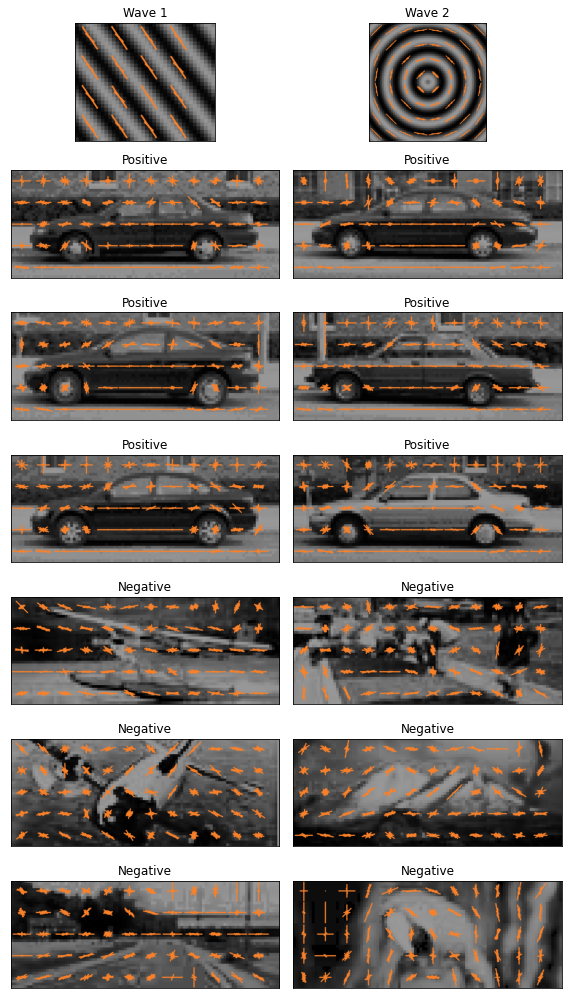

In [7]:
# Two simple wave images are here to help understand the visualization
waves = [iio.imread("sine.png"), iio.imread("circular_sine.jpg")]
images = waves + train_images_pos[:6] + train_images_neg[:6]
hogs = [hoglike_descriptor(image) for image in images]
hog_plots = [plot_hog(image, hog) for image, hog in zip(images, hogs)]
titles = ["Wave 1", "Wave 2"] + ["Positive"] * 6 + ["Negative"] * 6
plot_multiple(hog_plots, titles, max_columns=2, imheight=2, imwidth=4, share_axes=False)

Can you spot any interesting HOG-cells in the positive and negative examples that could be useful for telling cars apart from non-cars? 

*POINTS: 0*

YOUR ANSWER HERE

## Support Vector Machine for Classifying Image Windows

We now want to train a classifier in our HOG-like feature space to tell cars and non-cars apart. We use a simple linear SVM for this. 

Given the HOG representation of an image patch, the classifier should predict if the image patch corresponds to a car. The classifier will then be used to detect objects in new test images using sliding windows.

In [8]:
def train_svm(positive_hog_windows, negative_hog_windows):
    svm = sklearn.svm.LinearSVC(C=0.01, loss="hinge")
    hog_windows = np.concatenate([positive_hog_windows, negative_hog_windows])
    svm_input = hog_windows.reshape([len(hog_windows), -1])
    svm_target = np.concatenate(
        (
            np.full(len(positive_hog_windows), 1, dtype=np.float32),
            np.full(len(negative_hog_windows), 0, dtype=np.float32),
        )
    )
    svm.fit(svm_input, svm_target)
    return svm


def predict_svm(svm, hog_window):
    """Return the template response, i.e. the SVM's decision function without the sign."""
    return svm.decision_function(hog_window.reshape(1, -1))

In [9]:
start_time = time.time()
print("Computing features...")
positive_hog_windows = [hoglike_descriptor(im) for im in train_images_pos]
negative_hog_windows = [hoglike_descriptor(im) for im in train_images_neg]
duration = time.time() - start_time
print(f"Done. Took {duration:.2f} s.")

start_time = time.time()
print("Training SVM...")
svm = train_svm(positive_hog_windows, negative_hog_windows)
duration = time.time() - start_time
print(f"Done. Took {duration:.2f} s.")

Computing features...
Done. Took 1.85 s.
Training SVM...
Done. Took 0.02 s.


We can now visualize the SVM's weights. What do you observe?

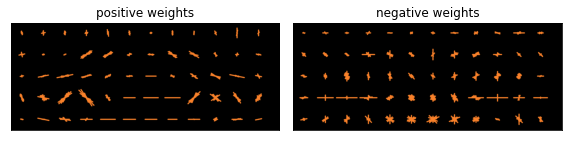

In [10]:
template = svm.coef_.reshape(
    positive_hog_windows[0].shape
)  # reshape weight vector to shape of HOG-descriptor
template_pos = (
    np.maximum(0, template) / template.max()
)  # we cannot visualize negative numbers, so separate
template_neg = (
    np.maximum(0, -template) / -template.min()
)  # them for independent visualization
hog_plots = [
    plot_hog(np.zeros_like(train_images_pos[0]), template_pos),
    plot_hog(np.zeros_like(train_images_pos[0]), template_neg),
]
titles = ["positive weights", "negative weights"]
plot_multiple(hog_plots, titles=titles, max_columns=2, imheight=2, imwidth=4)

*POINTS: 0*

YOUR ANSWER HERE

## Sliding Window-Based Detection

Now implement sliding window classification in the function `get_score_map`. It takes as input the trained classifier object `svm`, the HOG representation of a query image and `window_shape`, the shape of the sliding window (height, width). 

The function should slide a window over the HOG representation, compute the SVM's score for each window location, and return a score map. Notice that the score map will not have the same shape as the input HOG representation, it will be smaller because the full window needs to fit within the image (This is similar to the border effects from the earlier lectures, when sliding a convolutional kernel without padding lead to a smaller output image than the input).

Use `predict_svm(svm, hog_window)` to get the SVM's score for a HOG window. 

In [11]:
# POINTS: 3

def get_score_map(svm, hog, window_shape):
    
    height,width = window_shape
    
    window = np.array(hog.shape[:2])-window_shape+1
    score_map = np.empty(window,dtype=np.float32)
    
    for i,j in np.ndindex(*window):
        hog_window = hog[i:i+height,j:j+width]
    
        score_map[i,j] = predict_svm(svm,hog_window)
        
    return score_map

The next step is to convert the score map to actual detections. Implement the function `score_map_to_detections` which returns the indices as well as the values of scores that are higher than certain `threshold`.

In [12]:
# POINTS: 2

def score_map_to_detections(score_map, threshold):
    
    ys,xs = np.where(score_map>threshold)
    scores = score_map[ys,xs]
    
    return xs, ys, scores

Finally, we can test our car detector!

In [13]:
def draw_detections(image, xs, ys, scores, window_shape, cell_size=8):
    offset_size = 0

    h, w = image.shape[:2]
    scale_out = 5
    output_image = cv2.resize(
        image, (w * scale_out, h * scale_out), interpolation=cv2.INTER_NEAREST
    )
    if output_image.ndim < 3:
        output_image = cv2.cvtColor(output_image, cv2.COLOR_GRAY2RGB)
    output_image = (output_image.astype(np.float32) * 0.6).astype(np.uint8)

    window_size_out = np.array(window_shape[::-1]) * cell_size * scale_out
    color = (197, 255, 0)

    for x, y, score in zip(xs, ys, scores):
        im_p0 = (np.array([x, y]) * cell_size + offset_size) * scale_out
        im_p1 = im_p0 + window_size_out
        cv2.rectangle(
            output_image,
            tuple(im_p0),
            tuple(im_p1),
            color,
            thickness=3,
            lineType=cv2.LINE_AA,
        )
        cv2.putText(
            output_image,
            f"{score:.2f}",
            tuple(im_p0),
            cv2.FONT_HERSHEY_COMPLEX,
            1.5,
            color,
            thickness=2,
            lineType=cv2.LINE_AA,
        )
    return output_image

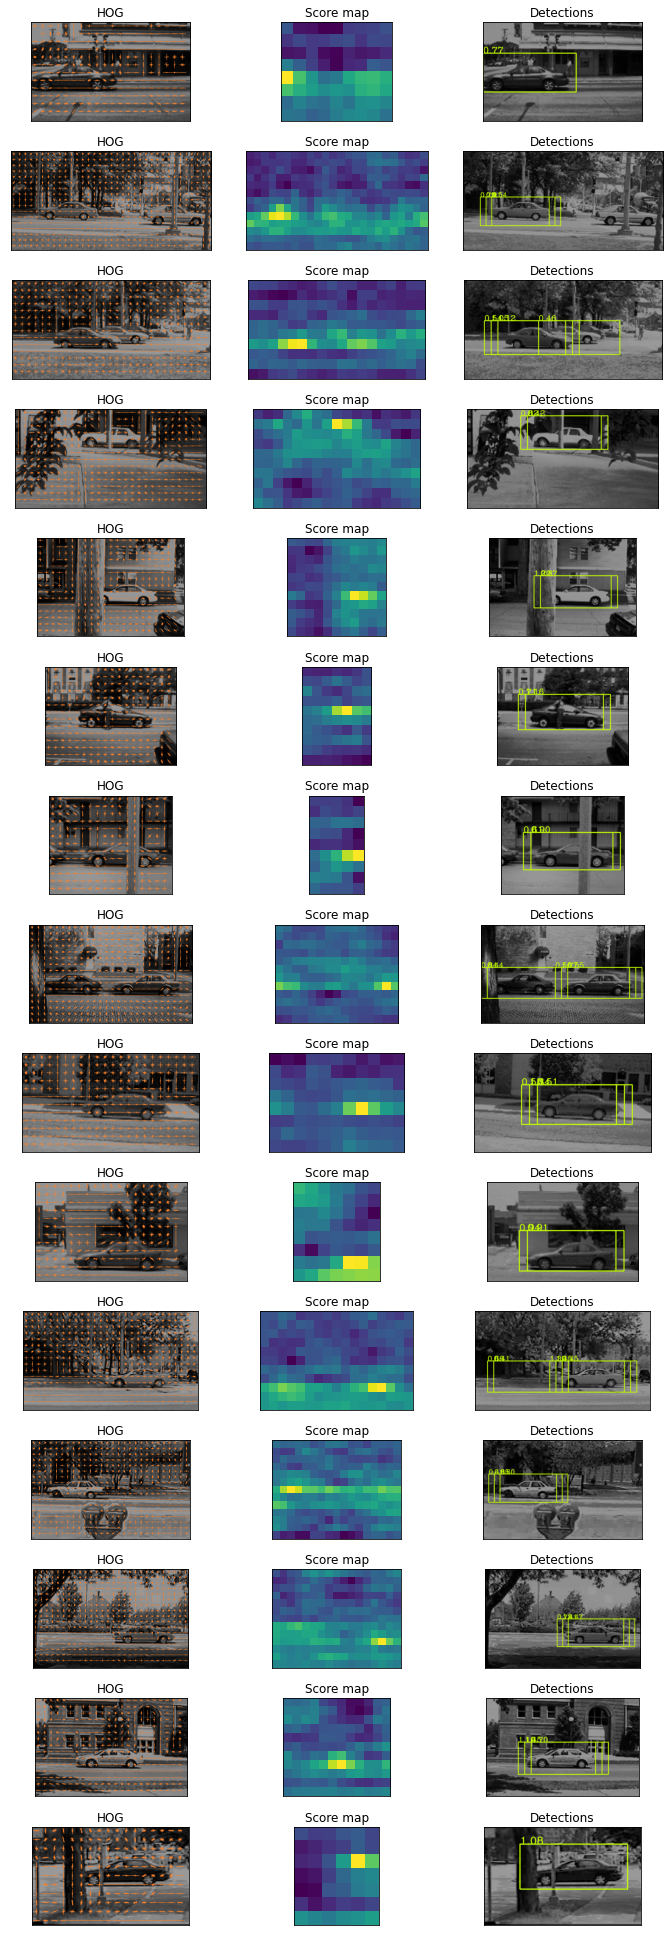

In [14]:
images, titles = [], []
window_shape = positive_hog_windows[0].shape[:2]

for test_image in test_images[25:40]:
    hog = hoglike_descriptor(test_image)
    score_map = get_score_map(svm, hog, window_shape)
    xs, ys, scores = score_map_to_detections(score_map, 0.4)
    detection_image = draw_detections(test_image, xs, ys, scores, window_shape)

    images += [plot_hog(test_image, hog), score_map, detection_image]
    titles += ["HOG", "Score map", "Detections"]

plot_multiple(images, titles, max_columns=3, imheight=1.8, imwidth=3.2)

## Non-Maximum Suppression

Sliding window based detectors often give multiple responses for the same target. A way to compensate such effect is to use non-maximum-suppression (NMS) on the score map. NMS simply looks at every pixel of the score map and keeps it only if it is the maximum in its 8-neighborhood (set it to the minimum value of the input score map otherwise). Implement `nms` which takes a score map, and returns the non-maximum-suppressed one.

In [17]:
# POINTS: 3

def nms(score_map):
    padded_scores = np.pad(score_map, [(1, 1), (1, 1)], 'constant')
    
    # Blur and add noise to break ties
    padded_scores = cv2.GaussianBlur(padded_scores, (3, 3), sigmaX=0.1)
    random = np.random.RandomState(seed=0)
    padded_scores += random.uniform(0, 1e-4, size=padded_scores.shape)
    nms_scores = np.zeros_like(padded_scores)
    
    for row in range(1, padded_scores.shape[0]-1):
        for col in range(1, nms_scores.shape[1]-1):
            current_score = padded_scores[row, col]

            # Get value of neighbor pixels
            col_neighbors = col + np.array([1, 1, 0, -1, -1, -1,  0,  1])
            row_neighbors = row + np.array([0, 1, 1,  1,  0, -1, -1, -1])
            neighbor_scores = padded_scores[row_neighbors, col_neighbors]
            
            # If the pixel value is larger than all neighbor values
            if np.all(neighbor_scores <= current_score):
                nms_scores[row, col] = current_score
    
    return nms_scores[1:-1, 1:-1]


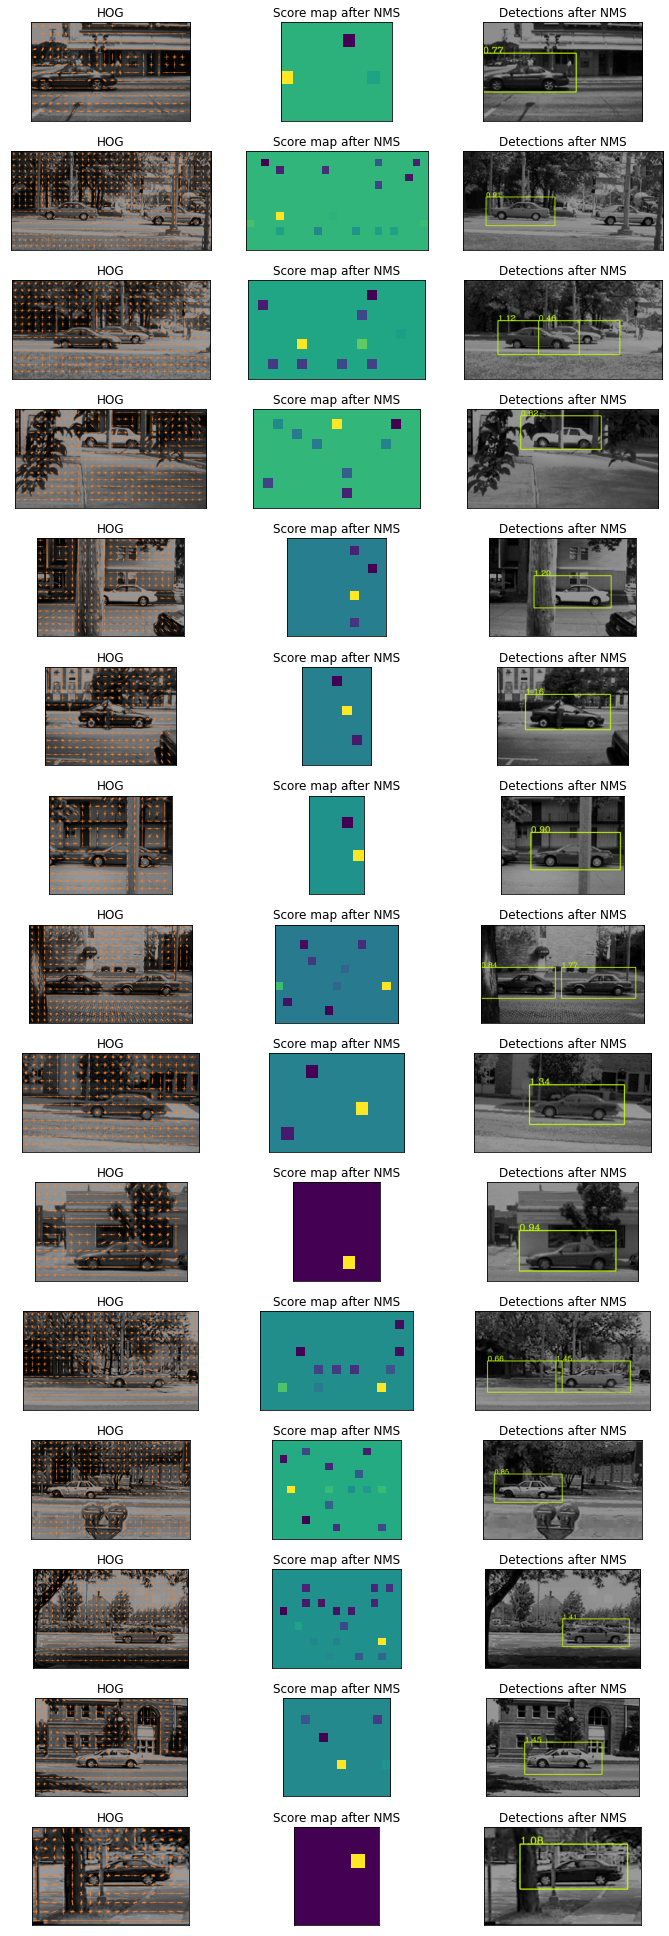

In [18]:
images, titles = [], []
for test_image in test_images[25:40]:
    hog = hoglike_descriptor(test_image)
    score_map = nms(get_score_map(svm, hog, window_shape))
    xs, ys, scores = score_map_to_detections(score_map, 0.4)
    detection_image = draw_detections(test_image, xs, ys, scores, window_shape)

    images += [plot_hog(test_image, hog), score_map, detection_image]
    titles += ["HOG", "Score map after NMS", "Detections after NMS"]

plot_multiple(images, titles, max_columns=3, imheight=1.8, imwidth=3.2)

Do you see wrong detections?

*POINTS: 0*

YOUR ANSWER HERE

Let's now evaluate the performance of our detector on the full UIUC test set. The dataset's zip contains a Java-based evaluation program, which we can call from this notebook (lines starting with ! are interpreted as shell commands in Jupyter Notebooks).

With a correct implementation the [F-measure](https://en.wikipedia.org/wiki/F-score) should be above 90%.

In [ ]:
def evaluate(
    test_images,
    svm,
    window_shape,
    descriptor_func=hoglike_descriptor,
    cell_size=8,
    threshold=0.4,
):
    # Write the detections to a file that is understood by the Java-based
    # evaluation program supplied with the dataset.
    with open("foundLocations.txt", "w") as f:
        for i, test_image in enumerate(test_images):
            hog = descriptor_func(test_image)
            score_map = nms(get_score_map(svm, hog, window_shape))
            xs, ys, scores = score_map_to_detections(score_map, threshold)

            f.write(f"{i}: ")
            for x, y in zip(xs, ys):
                f.write(f"({y*cell_size}, {x*cell_size}) ")
            f.write("\n")

    # Run the evaluation program on our generated file
    !java -classpath $dataset_dir Evaluator $dataset_dir/trueLocations.txt foundLocations.txt

evaluate(test_images, svm, window_shape, hoglike_descriptor, threshold=0.4)

## [OPTIONAL] Soft Assignment to Multiple Bins and Cells

In our `hoglike_descriptor`, we have used a simple assignment scheme of gradient vector to HOG bins. Each pixel voted for a single gradient orientation bin of a single spatial cell.

Now imagine if a gradient orientation falls on the end of an orientation bin. A small rotation would make it change to its neighboring bin, thus suddenly altering the HOG feature.

Similarly, imagine a pixel near the border between HOG-cells (spatially). A small translation of the object by a few pixels would make this gradient vote in the neighboring cell, again largely changing the features.

To make our descriptor more robust to small rotations and translations, let's replace this simple assignment scheme with a smooth voting. This will distribute the gradient magnitude over neighboring bins and cells.

In particular, we will use trilinear interpolation weights for weighting votes to neighboring bins. This is analogous to bilinear interpolation, but for three dimensional arrays. Remember that our descriptor is a three-dimensional array, and is indexed by two spatial cell indices and an orientation bin index. (If you don't know what bilinear interpolation is, read the first tutorial provided at the beginning of this exercise.)

Implement a `hoglike_descriptor_with_interp` function, which has same functionality and signature with `hoglike_descriptor` implemented earlier, but with simple assignment replaced with soft assignment according to trilinear interpolation weights.

In [ ]:
# POINTS: 0

def hoglike_descriptor_with_interp(image, cell_size=8, n_bins=16):
    # YOUR CODE HERE
    raise NotImplementedError()

    # Normalization
    bin_norm = np.linalg.norm(hog, axis=-1, keepdims=True)
    return hog / (bin_norm + 1e-4)

In [ ]:
start_time = time.time()
print("Computing features...")
descriptor_func = hoglike_descriptor_with_interp
positive_hog_windows = [descriptor_func(im) for im in train_images_pos]
negative_hog_windows = [descriptor_func(im) for im in train_images_neg]
duration = time.time() - start_time
print(f"Done. Took {duration:.2f} s.")

start_time = time.time()
print("Training SVM...")
svm2 = train_svm(positive_hog_windows, negative_hog_windows)
duration = time.time() - start_time
print(f"Done. Took {duration:.2f} s.")

In [ ]:
evaluate(test_images, svm2, window_shape, hoglike_descriptor_with_interp, threshold=0.4)

Congratulations, you have now implemented a car detector! To conclude, let's visualize it on different test images.

In [ ]:
def to_gray(im):
    if im.ndim < 3:
        return im
    else:
        return cv2.cvtColor(im, cv2.COLOR_RGB2GRAY)


streetview_images = [iio.imread(f"streetview{i}.jpg") for i in range(1, 4)]
some_uiuc_test_images = test_images[:33]

input_images = streetview_images + some_uiuc_test_images
detection_images = []

for test_image in input_images:
    hog = hoglike_descriptor_with_interp(to_gray(test_image))
    score_map = nms(get_score_map(svm2, hog, window_shape))
    xs, ys, scores = score_map_to_detections(score_map, 0.8)
    detection_image = draw_detections(test_image, xs, ys, scores, window_shape)
    detection_images.append(detection_image)

plot_multiple(detection_images[:3], max_columns=1, imheight=2, imwidth=6)
plot_multiple(detection_images[3:], max_columns=3, imheight=1.8, imwidth=3.2)